# Representing a double exponential convolution as an ODE
Special thanks to [DinosaurEgg on Math Stack Exchange](https://math.stackexchange.com/users/535606/dinosauregg) for [solving this when I was stuck](https://math.stackexchange.com/questions/4758246/stuck-on-inverse-laplace-transform-trying-to-convert-convolution-to-ode)!

[Song et al. (2021)](https://www.sciencedirect.com/science/article/pii/S0165027021001084) in the NAOMi simulator, convolve the intracellular calcium trace with a double exponential kernel to capture variable rise and decay times in the fluorescence signal.

Here's an example of what that looks like:

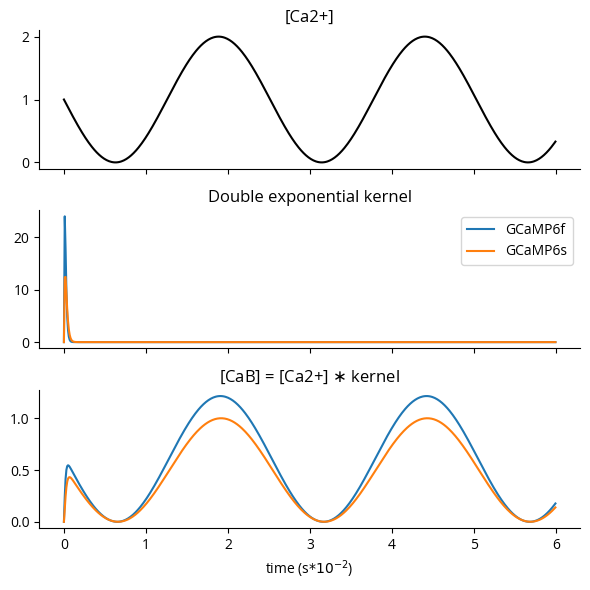

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def doub_exp(t, t_on=1, t_off=100, A=1):
    # the parameters t_on and t_off are actually 1/tau_on and 1/tau_off
    # and are defined in terms of seconds, not s/100, so we divide by 100
    # A in NAOMi implicitly includes their dt=0.01, so we divide that out
    A /= .01
    return A * (1 - np.exp(-t * t_on)) * np.exp(-t * t_off)

dt = .01
t = np.arange(0, 6, dt)

h6f = doub_exp(t, 0.85, 98.6, 76.1)
h6s = doub_exp(t, 0.45, 68.5, 54.7)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
def c(t):
    return -np.sin(t / .4) + 1

ax1.plot(t, c(t), label="Ca2+", c="k")
ax1.set(title="[Ca2+]")

ax2.plot(t, h6f, label="GCaMP6f")
ax2.plot(t, h6s, label="GCaMP6s")
ax2.set(title="Double exponential kernel")
ax2.legend()

b6f_conv = np.convolve(c(t), h6f)[: len(t)] * dt
b6s_conv = np.convolve(c(t), h6s)[: len(t)] * dt
ax3.plot(t, b6f_conv, label="GCaMP6f")
ax3.plot(t, b6s_conv, label="GCaMP6s")
ax3.set(title="[CaB] = [Ca2+] $\\ast$ kernel", xlabel="time (s$*10^{-2}$)")

fig.tight_layout()

$\def\lr#1{\left(#1\right)}$
$\def\inv#1{\frac{1}{#1}}$
$\def\Ton{T_\text{on}}$
$\def\Toff{T_\text{off}}$




To simplify simulation (to not have to keep a buffer of past calcium values), we can represent this convolution as an ODE.
Let $c(t)$ and $b(t)$ be the free and bound calcium concentrations and $h(t)$ be the kernel function.

$$ h(t) = u(t) A \lr{1 - e^{-t/\tau_{\text{on}}}} e^{-t/\tau_\text{off}} $$
$$ b(t) = c(t) \ast h(t) $$

where $u(t)$ is the unit step function, multiplied to ensure the kernel is causal.
We can represent the convolution as multiplication in the Laplace domain.

$$ B(s) = C(s) H(s) $$



By expanding out $h(t)$, we get functions that can easily be transformed into the Laplace domain.
Let $\kappa = \tau_\text{off}^{-1}, \lambda = \tau_\text{off}^{-1} + \tau_\text{on}^{-1}$ to simplify notation.

$$
\begin{aligned}
h(t) &= A u(t) \lr{1 - e^{-\Ton t}} e^{-\Toff t} \\
  &= A(u(t) e^{-\kappa t} - u(t) e^{-\lambda t}) \\
H(s) &= A\lr{\inv{s + \kappa} - \inv{s + \lambda}} \\
B(s) &= A\lr{\inv{s + \kappa} - \inv{s + \lambda}}C(s) \\
\end{aligned}
$$



Now we get a common denominator and rearrange:

$$
\begin{gathered}
B(s) = A\lr{\frac{\lambda-\kappa}{(s+\kappa)(s+\lambda)}}C(s) \\
B(s) = A\lr{\frac{\lambda-\kappa}{s^2+(\kappa+\lambda)s+\kappa\lambda}}C(s) \\
\lr{s^2+(\kappa+\lambda)s+\kappa\lambda}B(s) = A\lr{\lambda-\kappa}C(s) \\
\end{gathered}
$$


Now we use the $s^2$ and $s$ terms to convert to a second-order ODE, using the fact that the Laplace transform of $b''(t)$ and $b'(t)$  are $s^2B(s) - sb(0^-) - b(0^-)$ and $sB(s) - b(0^-)$, respectively.
Also, we assume that $b(0)=b'(0)=0$ to avoid pesky $\delta(t)$ and $\delta'(t)$ terms after the inverse Laplace transform (we'll see later this has only a minor effect).


$$b''(t) + (\kappa + \lambda)b'(t) + \kappa\lambda b(t) = A(\lambda-\kappa)c(t)$$

Rearranging to a first-order ODE system by introducing $\beta(t) = b'(t)$:

$$
\begin{aligned}
b'(t) &= \beta(t) \\
b''(t) = \beta'(t) &= A(\lambda-\kappa)c(t) - (\kappa + \lambda)\beta(t) - \kappa\lambda b(t) \\
\end{aligned}
$$

Now let's numerically solve the ODE and see if we get the same result as the convolution:

/tmp/ipykernel_27054/675053940.py:30: RuntimeWarning: invalid value encountered in divide
  ax2.plot(t, b6f_conv / b6f_ode[1], label="GCaMP6f")
/tmp/ipykernel_27054/675053940.py:31: RuntimeWarning: invalid value encountered in divide
  ax2.plot(t, b6s_conv / b6s_ode[1], label="GCaMP6s")


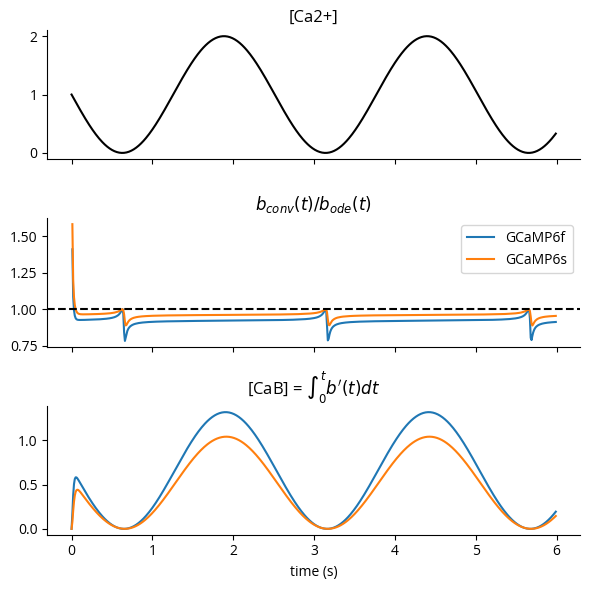

In [2]:
from scipy.integrate import solve_ivp

def sol_b(t_on, t_off, A, c=c):
    A /= .01
    kap = t_off
    lam = t_on + t_off

    def f(t, y):
        b, beta = y
        return [
            beta,
            (
                A * (lam - kap) * c(t)
                - (kap + lam) * beta
                - kap * lam * b
            ),
        ]

    sol = solve_ivp(f, [0, 6], [0, 0], t_eval=t)
    return sol.t, sol.y[0]


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
ax1.plot(t, c(t), label="Ca2+", c="k")
ax1.set(title="[Ca2+]")

b6f_ode = sol_b(0.85, 98.6, 76.1)
b6s_ode = sol_b(0.45, 68.5, 54.7)
ax2.set(title=r"$b_{conv}(t)/b_{ode}(t)$")
ax2.plot(t, b6f_conv / b6f_ode[1], label="GCaMP6f")
ax2.plot(t, b6s_conv / b6s_ode[1], label="GCaMP6s")
ax2.axhline(1, c="k", ls="--")
ax2.legend()

ax3.plot(*b6f_ode, label="GCaMP6f")
ax3.plot(*b6s_ode, label="GCaMP6s")
ax3.set(title="[CaB] = $\int_0^t b'(t)dt$", xlabel="time (s)")

fig.tight_layout()

We can see from the $b_\text{conv}/b_\text{ode}$ graph that the solutions are slightly different, but they're pretty close.
I assume this is a consequence of ignoring the $b(0)$ and $b'(0)$ terms in the inverse Laplace transform.

One more thing: since NAOMi performs the convolution without explicitly multiplying by `dt`, as we did before, we can assume that their `ca_amp` parameter is actually $A*\texttt{dt}$.
So in our ODE simulation we must use $A = \texttt{ca\_amp}/\texttt{dt}$.
By all appearances, `dt=1/100` (seconds) in their kernel fitting code.

Let's demonstrate that and make sure all units check out by simulating once more with Brian:

In [3]:
import brian2 as b2
b2.prefs.codegen.target = "numpy"

dt = b2.second
ng = b2.NeuronGroup(
    2,
    """
    c = nmolar * (-sin(t / (0.4*second)) + 1) : mmolar (shared)
    db/dt = beta : mmolar
    # lam = 1 / tau_on + 1 / tau_off : hertz
    # kap = 1 / tau_off : hertz
    lam = t_on + t_off : hertz
    kap = t_off : hertz
    dbeta/dt = A * (lam - kap) * c - (kap + lam) * beta - kap * lam * b : mmolar/second

    tau_on : second
    tau_off : second
    t_on : hertz
    t_off : hertz
    A : hertz
    """
)
ng.tau_on = [0.85, 0.45] * dt
ng.tau_off = [98.6, 68.5] * dt
ng.t_on = [0.85, 0.45] / dt
ng.t_off = [98.6, 68.5] / dt
ng.A = [76.1, 54.7] / (.01 * b2.second)

mon = b2.StateMonitor(ng, ["c", "b", "beta"], record=True)

net = b2.Network(ng, mon)
net.run(6 * b2.second)

WARNING    Variable c is a shared variable but it will be recorded once for every target. [brian2.monitors.statemonitor]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
WARNING    't' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value array([0.  , 0.01, 0.02, ..., 5.97, 5.98, 5.99]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


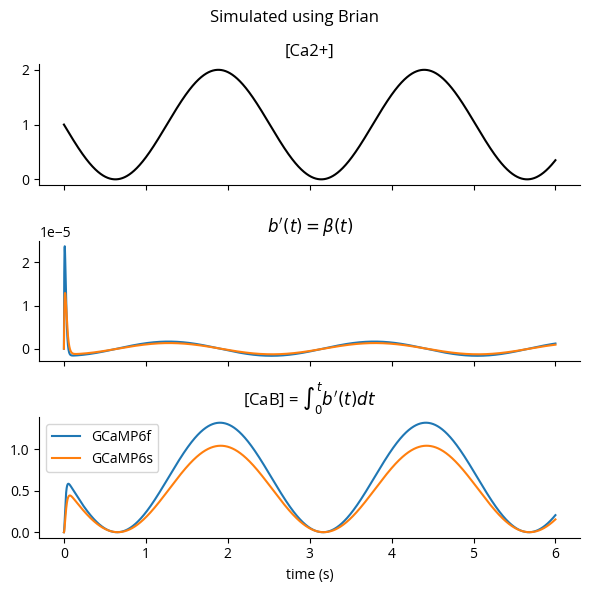

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
ax1.plot(mon.t / dt, mon.c[0] / b2.nmolar, label="Ca2+", c="k")
ax1.set(title="[Ca2+]")

ax2.plot(mon.t / dt, mon.beta.T, label="GCaMP6f")
ax2.set(title=r"$b'(t)=\beta(t)$")

ax3.plot(mon.t / dt, mon.b[0] / b2.nmolar, label="GCaMP6f")
ax3.plot(mon.t / dt, mon.b[1] / b2.nmolar, label="GCaMP6s")
ax3.set(title="[CaB] = $\int_0^t b'(t)dt$", xlabel="time (s)")
ax3.legend()

fig.suptitle("Simulated using Brian", y=.98)
fig.tight_layout()